<h1 align=center><font size = 5>Segmenting and Clustering Cities in Germany</font></h1>

Many cities in East and North German are suffering from a loss of population while the cities in West and South are gaining residents. Most likely the reasons for migration from East to West are to be found in the labor market

_But: is there a difference in these cities that adds to this?_

A city that offers many venues such as cafès, bars, cinemas, theaters etc. is more likely to hold its residents than a city that has a lower recreational value. So, let's start examining the largest german cities if there are similarities or differences in public life.

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:

import requests # library to handle requests
from bs4 import BeautifulSoup # for extracting data from html

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import json # library to handle JSON files
import sys

##########  geopy section #################
##
##  geopy relies on an openstreetmap web service which sometimes is slow and causes timeouts
##  => set hight timeout
##  see also: https://geopy.readthedocs.io/en/stable/
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from   geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.geocoders
# set geopy timeout
geopy.geocoders.options.default_timeout = 12


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Libraries imported.')

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Folium installed and imported.')



Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  13.59 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  28.09 MB/s
Libraries imported.
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   9.68 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  16.40 MB/s
vincent-0.4.4- 100% 

Do some basic definitions.

In [2]:
# basic definitions

# list of largest cities in Germany
url_ListOfGermanCities = "https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland"

# define min number of venue types a city should have 
min_num_venues = 15



## 1. Generate a list of cities incl. coordinates

#### Load list of the 80 biggest cities in Germany¶

In [3]:
# load html
bc_html  = requests.get(url_ListOfGermanCities).text
bc_soup  = BeautifulSoup(bc_html, 'html.parser')
bc_table = bc_soup.html.findAll('table')[0]
bc_table.tbody.tr.th.text

'Rang (2017)\n'

Build a dataframe

In [4]:

# copy data to dataframe
df_cities = pd.DataFrame(columns=['city','latd','long'])

for row in bc_table.find_all('tr'):
    #print(row)
    cols = row.find_all('td')
    if len(cols) > 0 :
        df_cities = df_cities.append({'city': cols[1].a.text }, ignore_index=True)

# test output, top 5
df_cities.head(5)

,city,latd,long
0,Berlin,NaN,NaN
1,Hamburg,NaN,NaN
2,München,NaN,NaN
3,Köln,NaN,NaN
4,Frankfurt am Main,NaN,NaN


Now fill longitude and latitude columns with Nominatim()¶

In [5]:

geolocator = Nominatim()

for index, row in df_cities.iterrows():
    city = row['city'] 
    sys.stdout.write(city + ' ')
    location    = geolocator.geocode( city )
    if location:
        row['latd'] = location.latitude
        row['long'] = location.longitude
    else:
        print('\n**** Error on retrieving data for ' + city + ' ****')

df_cities.head(5)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


Berlin Hamburg München Köln Frankfurt am Main Stuttgart Düsseldorf Dortmund Essen Leipzig Bremen Dresden Hannover Nürnberg Duisburg Bochum Wuppertal Bielefeld Bonn Münster Karlsruhe Mannheim Augsburg Wiesbaden Mönchen­gladbach 
**** Error on retrieving data for Mönchen­gladbach ****
Gelsenkirchen Braunschweig Kiel Chemnitz Aachen Halle (Saale) Magdeburg Freiburg im Breisgau Krefeld Lübeck Mainz Erfurt Oberhausen Rostock Kassel Hagen Saarbrücken Hamm Potsdam Mülheim an der Ruhr Ludwigshafen am Rhein Oldenburg (Oldb) Osnabrück Leverkusen Heidelberg Solingen Darmstadt Herne Neuss Regensburg Paderborn Ingolstadt Offenbach am Main Würzburg Fürth Ulm Heilbronn Pforzheim Wolfsburg Göttingen Bottrop Reutlingen Koblenz Recklinghausen Bremer­haven Bergisch Gladbach Jena Erlangen Remscheid Trier Salzgitter Moers Siegen Hildesheim Cottbus 

,city,latd,long
0,Berlin,52.517,13.3889
1,Hamburg,53.5503,10.0007
2,München,48.1371,11.5754
3,Köln,50.9384,6.95997
4,Frankfurt am Main,50.1106,8.68209


Remove rows with not long/latd data

In [6]:
# no geo data for Mönchengladbach; reason unclear => drop
print('before: ' + str(df_cities.shape))
df_cities.dropna(inplace=True)
print('after:  ' + str(df_cities.shape))

before: (80, 3)
after:  (79, 3)


## 2.  Explore Dataset

Copy the data to a new dataframe.

In [7]:
df_base = df_cities
df_base.rename(columns={"city":"City", "latd":"Latd", "long":"Long"},inplace=True)
df_base.set_index('City',inplace=True)
df_base.head()

,Latd,Long
City,,
Berlin,52.517,13.3889
Hamburg,53.5503,10.0007
München,48.1371,11.5754
Köln,50.9384,6.95997
Frankfurt am Main,50.1106,8.68209


Get the coord. of the geogr. center of Germany which is Mühlhausen acc. to https://de.wikipedia.org/wiki/Mittelpunkt_Deutschlands

In [8]:
address = 'Mühlhausen, Thüringen'

geolocator = Nominatim()
location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude

# if: trouble with Nominatim Service => hard encoded long/latt
#latitude  = 
#longitude = 

print('The geograpical center is {}, {}.'.format(latitude, longitude))


The geograpical center is 51.2396368, 10.4867935615622.


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


#### Create a map of Germany with cities superimposed on top.

In [9]:
# create map using latitude and longitude values
map_overview = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
cnt=0
for lat, lng, city in zip(df_base['Latd'], df_base['Long'], df_base.index.values):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    cnt=cnt+1
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup  = label,
        color  = 'blue',
        fill   = True,
        fill_color   = '#3186cc',
        fill_opacity = 0.7,
        parse_html   = False).add_to(map_overview)  
    
map_overview


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [10]:
CLIENT_ID     = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION       = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: OZ1KZUBADNBJNXD32MJ2FWJ0XQF50CMVQK0U12I4JXBTWIE3
CLIENT_SECRET:0VZBD2GZM13QWJ3XOKOB3L4FHEC3RVXXAORUBD0NI1WH2XFI


#### Let's explore the first city in our dataframe.¶

Get the cities name.

In [11]:
df_base.index[0]


'Berlin'

get the neighborhood's latitude and longitude values.

In [12]:
sample_name      = df_base.index[0] # city name
sample_latitude  = df_base.Latd[0]  # latitude value
sample_longitude = df_base.Long[0]  #  longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(sample_name, 
                                                               sample_latitude, 
                                                               sample_longitude))

Latitude and longitude values of Berlin are 52.5170365, 13.3888599.


#### Now, let's get the top 100 venues that are at the respective city within a radius of 1000 meters.

First, let's create the GET request URL. Name your URL **url**.

In [13]:

LIMIT  = 100   # limit of number of venues returned by Foursquare API
radius = 1000  # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    sample_latitude, 
    sample_longitude, 
    radius, 
    LIMIT)

url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=OZ1KZUBADNBJNXD32MJ2FWJ0XQF50CMVQK0U12I4JXBTWIE3&client_secret=0VZBD2GZM13QWJ3XOKOB3L4FHEC3RVXXAORUBD0NI1WH2XFI&v=20180605&ll=52.5170365,13.3888599&radius=1000&limit=100'

Send the GET request and examine the results

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c3cec036a607129e2fd4cac'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4adcda8ef964a520a74a21e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bookstore_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d114951735',
         'name': 'Bookstore',
         'pluralName': 'Bookstores',
         'primary': True,
         'shortName': 'Bookstore'}],
       'id': '4adcda8ef964a520a74a21e3',
       'location': {'address': 'Friedrichstr. 90',
        'cc': 'DE',
        'city': 'Berlin',
        'country': 'Deutschland',
        'distance': 151,
        'formattedAddress': ['Friedrichstr. 90',
         '10117 Berlin',
         'Deutschland'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 52.5183981953

All the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


Now we are ready to clean the json and structure it into a pandas dataframe.

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


,name,categories,lat,lng
0,Dussmann das KulturKaufhaus,Bookstore,52.518398,13.388788
1,Cookies Cream,Vegetarian / Vegan Restaurant,52.516569,13.388008
2,Dussmann English Bookshop,Bookstore,52.518223,13.389239
3,COS,Clothing Store,52.515698,13.389298
4,Komische Oper,Opera House,52.515968,13.386701


And how many venues were returned by Foursquare?

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## 3. Explore cities in Germany

#### Let's create a function to repeat the same process to all the bigger cities in Germany

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        sys.stdout.write(name + ' ')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print('\n**** Error retrieving data for ' + name + ' ****')
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now run the above function on each city and create a new dataframe called city_venues.

In [21]:
city_venues = getNearbyVenues(
    names      = df_base.index.values,
    latitudes  = df_base['Latd'],
    longitudes = df_base['Long']
)

Berlin Hamburg München Köln Frankfurt am Main Stuttgart Düsseldorf Dortmund Essen Leipzig Bremen Dresden Hannover Nürnberg Duisburg Bochum Wuppertal Bielefeld Bonn Münster Karlsruhe Mannheim Augsburg Wiesbaden Gelsenkirchen Braunschweig Kiel Chemnitz Aachen Halle (Saale) Magdeburg Freiburg im Breisgau Krefeld Lübeck Mainz Erfurt Oberhausen Rostock Kassel Hagen Saarbrücken Hamm Potsdam Mülheim an der Ruhr Ludwigshafen am Rhein Oldenburg (Oldb) Osnabrück Leverkusen Heidelberg Solingen Darmstadt Herne Neuss Regensburg Paderborn Ingolstadt Offenbach am Main Würzburg Fürth Ulm Heilbronn Pforzheim Wolfsburg Göttingen Bottrop Reutlingen Koblenz Recklinghausen Bremer­haven Bergisch Gladbach Jena Erlangen Remscheid Trier Salzgitter Moers Siegen Hildesheim Cottbus 

#### Let's check the size of the resulting dataframe

In [22]:
print(city_venues.shape)
city_venues.head()

(4027, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,52.518398,13.388788,Bookstore
1,Berlin,52.517037,13.38886,Cookies Cream,52.516569,13.388008,Vegetarian / Vegan Restaurant
2,Berlin,52.517037,13.38886,Dussmann English Bookshop,52.518223,13.389239,Bookstore
3,Berlin,52.517037,13.38886,COS,52.515698,13.389298,Clothing Store
4,Berlin,52.517037,13.38886,Komische Oper,52.515968,13.386701,Opera House


Let's check how many venues were returned for each city.

In [23]:
df_count = city_venues.groupby('City').count()[['Venue']]
df_count.rename(columns={"Venue":"Num_Venues"},inplace=True)
df_count

,Num_Venues
City,
Aachen,100
Augsburg,41
Bergisch Gladbach,24
Berlin,84
Bielefeld,5
Bochum,74
Bonn,89
Bottrop,19
Braunschweig,100


Visualize the distribution of returned data.

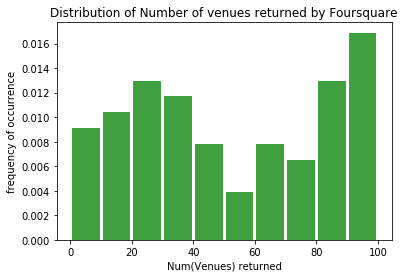

In [27]:
# the histogram of the data
n, bins, patches = plt.hist(df_count['Num_Venues'], 10, range=[0,100], normed=1, facecolor='green', alpha=0.75, rwidth=0.9)

plt.xlabel('Num(Venues) returned')
plt.ylabel('frequency of occurrence')
plt.title('Distribution of Number of venues returned by Foursquare')
plt.show()

Let's see for how many cities there's less than 10 venues reported - we've got to exclude them from the machine learnign part.

In [28]:
df_drop = df_count[ df_count['Num_Venues'] < min_num_venues ]
print('For ' + str(df_drop.shape[0]) + ' cities the Foursquare API delivered less than ' + str(min_num_venues) + ' venues')
df_drop


For 10 cities the Foursquare API delivered less than 15 venues


,Num_Venues
City,
Bielefeld,5
Freiburg im Breisgau,6
Hamm,4
Kassel,11
Ludwigshafen am Rhein,5
Münster,4
Osnabrück,12
Paderborn,6
Remscheid,11


Now drop the cities with to few information

In [30]:
for row in df_count[ df_count['Num_Venues'] < min_num_venues ].iterrows():
    city2drop = row[0]
    print(city2drop)
    city_venues = city_venues[~city_venues.City.str.contains(city2drop) ]

city_venues.shape

Bielefeld
Freiburg im Breisgau
Hamm
Kassel
Ludwigshafen am Rhein
Münster
Osnabrück
Paderborn
Remscheid
Wuppertal


(3954, 7)

Count the cities that are left

In [31]:
city_venues.groupby('City')['City'].nunique().count()

67

#### Let's find out how many unique categories can be curated from all the returned venues

In [32]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 271 uniques categories.


## 4. Analyze Each City

Convert the data into an one hot dataframe.

In [33]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Casino,Castle,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kumpir Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Night Market,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pharmacy,Photography Studio,Pide Place,Pizza Place,Planetarium,Platform,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Street Fair,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tourist Information Center,Toy / Game Store,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store
0,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [34]:
city_onehot.shape

(3954, 272)

#### Next, let's group rows by city and by taking the mean of the frequency of occurrence of each category

In [35]:
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Casino,Castle,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kumpir Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Night Market,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pharmacy,Photography Studio,Pide Place,Pizza Place,Planetarium,Platform,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Street Fair,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tourist Information Center,Toy / Game Store,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store
0,Aachen,0.00000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.030000,0.000000,0.030000,0.000000,

#### Let's confirm the new size


In [36]:
city_grouped.shape

(67, 272)

#### Let's print each city along with the top 5 most common venues

In [37]:
num_top_venues = 5

for hood in city_grouped['City']:
    print("---- " + hood + " ----")
    temp = city_grouped[city_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Aachen ----
                venue  freq
0  Italian Restaurant  0.06
1                Café  0.05
2      Ice Cream Shop  0.05
3           Drugstore  0.05
4    Sushi Restaurant  0.04


---- Augsburg ----
                venue  freq
0               Plaza  0.10
1                Café  0.10
2  Italian Restaurant  0.07
3       Historic Site  0.05
4           Drugstore  0.05


---- Bergisch Gladbach ----
                venue  freq
0  Italian Restaurant  0.08
1                Café  0.08
2       Shopping Mall  0.08
3      Clothing Store  0.08
4           BBQ Joint  0.04


---- Berlin ----
               venue  freq
0              Hotel  0.10
1  German Restaurant  0.07
2        Coffee Shop  0.06
3     Clothing Store  0.05
4               Café  0.05


---- Bochum ----
            venue  freq
0          Bakery  0.07
1  Ice Cream Shop  0.05
2            Café  0.04
3             Bar  0.04
4      Restaurant  0.03


---- Bonn ----
               venue  freq
0                Bar  0.07
1            

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each city.

In [39]:
num_top_venues = min_num_venues

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.set_index('City',inplace=True)
city_venues_sorted

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,
Aachen,Italian Restaurant,Ice Cream Shop,Café,Drugstore,Sushi Restaurant,Coffee Shop,Hotel,German Restaurant,Bar,Bakery,Plaza,Nightclub,Pizza Place,Falafel Restaurant,Burger Joint
Augsburg,Plaza,Café,Italian Restaurant,Historic Site,Bar,Drugstore,Farmers Market,French Restaurant,Mexican Restaurant,Burger Joint,Seafood Restaurant,Fast Food Restaurant,Falafel Restaurant,German Restaurant,Restaurant
Bergisch Gladbach,Shopping Mall,Clothing Store,Italian Restaurant,Café,Steakhouse,Supermarket,Electronics Store,German Restaurant,Restaurant,Juice Bar,Drugstore,Bookstore,Bakery,BBQ Joint,Ice Cream Shop
Berlin,Hotel,German Restaurant,Coffee Shop,Clothing Store,Café,Italian Restaurant,Wine Bar,Hotel Bar,Theater,Opera House,Cosmetics Shop,Concert Hall,Cocktail Bar,Plaza,Restaurant
Bochum,Bakery,Ice Cream Shop,Café,Bar,Drugstore,Bookstore,BBQ Joint,Coffee Shop,Toy / Game Store,Sushi Restaurant,Soup Place,Falafel Restaurant,Hookah Bar,German Restaurant,Burger Joint
Bonn,Bar,Plaza,Café,German Restaurant,Nightclub,Italian Restaurant,Bakery,Pub,Restaurant,Burger Joint,Falafel Restaurant,Cocktail Bar,Indian Restaurant,Chinese Restaurant,Ice Cream Shop
Bottrop,Café,Plaza,Gas Station,Bar,Pub,Clothing Store,Restaurant,Discount Store,Fast Food Restaurant,Steakhouse,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Hotel,Gym
Braunschweig,Café,Clothing Store,Bar,Italian Restaurant,Hotel,Supermarket,Drugstore,German Restaurant,Burger Joint,Plaza,Fast Food Restaurant,Coffee Shop,Turkish Restaurant,Department Store,Ice Cream Shop
Bremen,Café,German Restaurant,Restaurant,Clothing Store,Drugstore,Hotel,Asian Restaurant,Plaza,Outdoor Sculpture,Italian Restaurant,Candy Store,Steakhouse,Falafel Restaurant,Bar,Seafood Restaurant


## 5. Cluster Neighborhoods


Run k-means to cluster the cities into 10 clusters.

In [40]:
# prepare data
city_grouped_clustering = city_grouped.drop('City', 1)

# save results in arrays for plotting later
k = []
c = []

# calc!
for kclusters in range(2,15):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)
    print("k: " + str(kclusters) + "  cost: " + str(kmeans.inertia_) )
    k.append(kclusters)
    c.append(kmeans.inertia_)


k: 2  cost: 1.40889691131
k: 3  cost: 1.29733019354
k: 4  cost: 1.23662397479
k: 5  cost: 1.18799402143
k: 6  cost: 1.12755921236
k: 7  cost: 1.10395357524
k: 8  cost: 1.03820725672
k: 9  cost: 0.998576633408
k: 10  cost: 0.976727851367
k: 11  cost: 0.940269545841
k: 12  cost: 0.914421655892
k: 13  cost: 0.862489751039
k: 14  cost: 0.829497892981


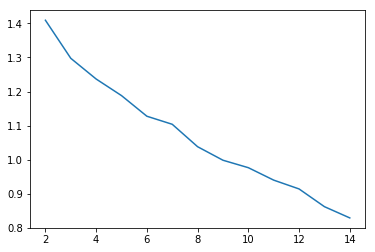

In [41]:
# show the cost by k as graph
import matplotlib.pyplot as plt
plt.plot(k, c)
plt.show()

Set k to 5 and build a model

In [42]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

Now, start with generating a dataframe with the names of the cities

In [43]:
city_merged = city_grouped[['City']]
city_merged.set_index('City',inplace=True)
city_merged.shape

(67, 0)

Add latitude and longitude

In [44]:
city_merged = pd.merge( city_merged, df_base, left_index=True, right_index=True)
city_merged.head()

,Latd,Long
City,,
Aachen,50.7764,6.08386
Augsburg,48.3668,10.8987
Bergisch Gladbach,50.9929,7.12774
Berlin,52.517,13.3889
Bochum,51.4818,7.21966


Extend the new dataframe by teh cluster label and the top 10 venues for each city.

In [45]:
# add clustering labels
city_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.merge(city_venues_sorted,left_index=True, right_index=True)

city_merged.head() # check the last columns!

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,
Aachen,50.7764,6.08386,2,Italian Restaurant,Ice Cream Shop,Café,Drugstore,Sushi Restaurant,Coffee Shop,Hotel,German Restaurant,Bar,Bakery,Plaza,Nightclub,Pizza Place,Falafel Restaurant,Burger Joint
Augsburg,48.3668,10.8987,2,Plaza,Café,Italian Restaurant,Historic Site,Bar,Drugstore,Farmers Market,French Restaurant,Mexican Restaurant,Burger Joint,Seafood Restaurant,Fast Food Restaurant,Falafel Restaurant,German Restaurant,Restaurant
Bergisch Gladbach,50.9929,7.12774,1,Shopping Mall,Clothing Store,Italian Restaurant,Café,Steakhouse,Supermarket,Electronics Store,German Restaurant,Restaurant,Juice Bar,Drugstore,Bookstore,Bakery,BBQ Joint,Ice Cream Shop
Berlin,52.517,13.3889,2,Hotel,German Restaurant,Coffee Shop,Clothing Store,Café,Italian Restaurant,Wine Bar,Hotel Bar,Theater,Opera House,Cosmetics Shop,Concert Hall,Cocktail Bar,Plaza,Restaurant
Bochum,51.4818,7.21966,2,Bakery,Ice Cream Shop,Café,Bar,Drugstore,Bookstore,BBQ Joint,Coffee Shop,Toy / Game Store,Sushi Restaurant,Soup Place,Falafel Restaurant,Hookah Bar,German Restaurant,Burger Joint


Finally, let's visualize the resulting clusters

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = ['Yellow','Red','Green','Blue','Cyan']
for lat, lon, poi, cluster in zip(city_merged['Latd'], city_merged['Long'], city_merged.index.values, city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Finalley, we examine the clusters and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Overview: how many entries are in which cluster?

In [47]:
for i in range(0,kclusters):
    print('Cluster ' + str(i) + ': ' + str(city_merged.loc[city_merged['Cluster Labels'] == i ]['Cluster Labels'].count()) + ' elements')

Cluster 0: 8 elements
Cluster 1: 10 elements
Cluster 2: 49 elements


#### Cluster 1

In [48]:
city_merged.loc[city_merged['Cluster Labels'] == 0 ]

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,
Bottrop,51.5216,6.9292,0,Café,Plaza,Gas Station,Bar,Pub,Clothing Store,Restaurant,Discount Store,Fast Food Restaurant,Steakhouse,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Hotel,Gym
Göttingen,51.5328,9.93521,0,Café,Drugstore,Italian Restaurant,Supermarket,Bar,Pub,Bakery,German Restaurant,Ice Cream Shop,Clothing Store,Middle Eastern Restaurant,Outdoor Sculpture,Restaurant,Bookstore,Steakhouse
Ingolstadt,48.763,11.425,0,Café,Bar,Italian Restaurant,German Restaurant,Greek Restaurant,Plaza,Museum,Steakhouse,Spanish Restaurant,Lounge,Mexican Restaurant,Burger Joint,Mediterranean Restaurant,Salad Place,Beer Garden
Krefeld,51.3331,6.56233,0,Café,Clothing Store,Italian Restaurant,Bakery,Fast Food Restaurant,Bar,Cosmetics Shop,Bookstore,Burger Joint,Shopping Mall,Department Store,Coffee Shop,Drugstore,Mexican Restaurant,Mediterranean Restaurant
Neuss,51.1982,6.69165,0,Café,Italian Restaurant,Bar,German Restaurant,Lounge,Clothing Store,Supermarket,Turkish Restaurant,Drugstore,Department Store,Bakery,Bistro,Pub,Beer Garden,Smoke Shop
Recklinghausen,51.6144,7.19785,0,Italian Restaurant,Café,Clothing Store,Bar,Drugstore,Train Station,Supermarket,Multiplex,Pub,Falafel Restaurant,Electronics Store,Shopping Mall,Burger Joint,German Restaurant,Hotel
Reutlingen,48.492,9.21141,0,Café,Bar,Clothing Store,Ice Cream Shop,Restaurant,Drugstore,Bakery,Italian Restaurant,Mexican Restaurant,Bus Stop,Spanish Restaurant,Bookstore,Multiplex,Gastropub,Japanese Restaurant
Siegen,50.875,8.02272,0,Café,Nightclub,Clothing Store,Steakhouse,Sushi Restaurant,Mediterranean Restaurant,Bar,Drugstore,Bakery,Supermarket,Frozen Yogurt Shop,Multiplex,Gym / Fitness Center,Department Store,Fast Food Restaurant


#### Cluster 2

In [49]:
city_merged.loc[city_merged['Cluster Labels'] == 1 ]

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,
Bergisch Gladbach,50.9929,7.12774,1,Shopping Mall,Clothing Store,Italian Restaurant,Café,Steakhouse,Supermarket,Electronics Store,German Restaurant,Restaurant,Juice Bar,Drugstore,Bookstore,Bakery,BBQ Joint,Ice Cream Shop
Gelsenkirchen,51.511,7.09601,1,Ice Cream Shop,Clothing Store,Drugstore,Light Rail Station,Supermarket,Sushi Restaurant,Café,Chinese Restaurant,Music Venue,Restaurant,Sporting Goods Shop,Business Service,Spanish Restaurant,Italian Restaurant,Cocktail Bar
Hagen,51.3583,7.4733,1,Clothing Store,Ice Cream Shop,Theater,Bakery,Shopping Mall,Men's Store,Fast Food Restaurant,Café,Bookstore,Supermarket,Electronics Store,Beer Bar,Cocktail Bar,Bar,Drugstore
Herne,51.538,7.21999,1,Drugstore,Bus Stop,Asian Restaurant,Supermarket,Clothing Store,Café,Italian Restaurant,Museum,Gastropub,Pastry Shop,Ice Cream Shop,Movie Theater,Performing Arts Venue,Burger Joint,Fast Food Restaurant
Leverkusen,51.0325,6.98812,1,Italian Restaurant,Bakery,Clothing Store,Platform,Shopping Mall,Burger Joint,Bus Stop,Multiplex,Café,Steakhouse,Supermarket,Electronics Store,Chinese Restaurant,Restaurant,Theater
Magdeburg,52.1316,11.64,1,Italian Restaurant,Drugstore,Supermarket,Ice Cream Shop,Shopping Mall,Tram Station,Chinese Restaurant,Café,Clothing Store,Thai Restaurant,Bakery,Bookstore,Electronics Store,Plaza,Indian Restaurant
Moers,51.4513,6.62843,1,Italian Restaurant,Clothing Store,Ice Cream Shop,Café,Irish Pub,Electronics Store,Drugstore,Bakery,Breakfast Spot,American Restaurant,Flea Market,Food,Ethiopian Restaurant,Fish Market,Fast Food Restaurant
Mülheim an der Ruhr,51.4273,6.88292,1,Drugstore,Italian Restaurant,Ice Cream Shop,Supermarket,Plaza,Toy / Game Store,Pub,Movie Theater,Clothing Store,Bar,Bakery,German Restaurant,Café,River,Tram Station
Oberhausen,51.514,6.84932,1,Bakery,Supermarket,Sandwich Place,Chinese Restaurant,Drugstore,Bank,Big Box Store,Train Station,Tram Station,Pub,Italian Restaurant,Farmers Market,Ice Cream Shop,Bus Station,Fast Food Restaurant


#### Cluster 3

In [50]:
city_merged.loc[city_merged['Cluster Labels'] == 2 ]

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,
Aachen,50.7764,6.08386,2,Italian Restaurant,Ice Cream Shop,Café,Drugstore,Sushi Restaurant,Coffee Shop,Hotel,German Restaurant,Bar,Bakery,Plaza,Nightclub,Pizza Place,Falafel Restaurant,Burger Joint
Augsburg,48.3668,10.8987,2,Plaza,Café,Italian Restaurant,Historic Site,Bar,Drugstore,Farmers Market,French Restaurant,Mexican Restaurant,Burger Joint,Seafood Restaurant,Fast Food Restaurant,Falafel Restaurant,German Restaurant,Restaurant
Berlin,52.517,13.3889,2,Hotel,German Restaurant,Coffee Shop,Clothing Store,Café,Italian Restaurant,Wine Bar,Hotel Bar,Theater,Opera House,Cosmetics Shop,Concert Hall,Cocktail Bar,Plaza,Restaurant
Bochum,51.4818,7.21966,2,Bakery,Ice Cream Shop,Café,Bar,Drugstore,Bookstore,BBQ Joint,Coffee Shop,Toy / Game Store,Sushi Restaurant,Soup Place,Falafel Restaurant,Hookah Bar,German Restaurant,Burger Joint
Bonn,50.7359,7.10066,2,Bar,Plaza,Café,German Restaurant,Nightclub,Italian Restaurant,Bakery,Pub,Restaurant,Burger Joint,Falafel Restaurant,Cocktail Bar,Indian Restaurant,Chinese Restaurant,Ice Cream Shop
Braunschweig,52.2647,10.5236,2,Café,Clothing Store,Bar,Italian Restaurant,Hotel,Supermarket,Drugstore,German Restaurant,Burger Joint,Plaza,Fast Food Restaurant,Coffee Shop,Turkish Restaurant,Department Store,Ice Cream Shop
Bremen,53.0758,8.80716,2,Café,German Restaurant,Restaurant,Clothing Store,Drugstore,Hotel,Asian Restaurant,Plaza,Outdoor Sculpture,Italian Restaurant,Candy Store,Steakhouse,Falafel Restaurant,Bar,Seafood Restaurant
Chemnitz,50.8323,12.9253,2,German Restaurant,Pub,Café,Sushi Restaurant,Bistro,Cultural Center,Drugstore,Cocktail Bar,Clothing Store,Light Rail Station,Bar,Sporting Goods Shop,French Restaurant,Electronics Store,Multiplex
Cottbus,51.7567,14.3357,2,German Restaurant,Hotel,Gym / Fitness Center,Burger Joint,Movie Theater,Shopping Mall,Bowling Alley,Café,Greek Restaurant,Clothing Store,Bar,Coffee Shop,Food Service,Asian Restaurant,Concert Hall


#### Cluster 4

In [51]:
city_merged.loc[city_merged['Cluster Labels'] == 3 ]

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,


#### Cluster 5

In [52]:
city_merged.loc[city_merged['Cluster Labels'] == 4 ]

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,


#### Cluster 6

In [53]:
city_merged.loc[city_merged['Cluster Labels'] == 5 ]

,Latd,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
City,,,,,,,,,,,,,,,,,,
